In [15]:
import cv2
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt

import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

In [2]:
def getLineCount(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = cv2.GaussianBlur(image, (5, 5), 0)
    image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (20, 5))
    image = cv2.dilate(image, kernel, iterations=1)


    contours = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    
    return len(contours)

def getWordCount(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = cv2.GaussianBlur(image, (5, 5), 0)
    image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    image = cv2.dilate(image, kernel, iterations=1)


    contours = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    
    return len(contours)


def getParagraphCount(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = cv2.GaussianBlur(image, (5, 5), 0)
    image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    image = cv2.dilate(image, kernel, iterations=3)


    contours = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    
    return len(contours)


def getBackgroundColor(image):
    colorFreq = {}
    width, length, _ = image.shape
    
    for row in range(width):
        for column in range(length):
            pw = tuple(image[row, column])
            if pw not in colorFreq:
                colorFreq[pw] = 0
            colorFreq[pw]= colorFreq[pw] + 1
    backgroundColor = max(colorFreq, key=colorFreq.get)
    return backgroundColor

def contourWikipage(image):
    
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    image = cv2.GaussianBlur(image, (5, 5), 0)
    image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (6,10))
    image = cv2.dilate(image, kernel, iterations=3)

    contours = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    
    return contours


def checkWikiTextContent(image):
    wordCount = getWordCount(image)
    sentenceCount = getLineCount(image)
    backgroundColor = getBackgroundColor(image)
    
    if sentenceCount>=2 and wordCount/sentenceCount >= 10:
        if backgroundColor == (255, 255, 255):
            return True
    return False

In [3]:
def plotImage(image, contours = None, figsize=(10, 30)):
    
    if contours is not None:
        for contour in contours:
            x,y,w,h = cv2.boundingRect(contour)
            cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 2)
    
    fig, ax = plt.subplots(figsize=figsize)
    plt.imshow(image)
    plt.show()
    
    return None

(44, 90, 3)
(45, 92, 3)
(117, 1065, 3)
(37, 147, 3)
(40, 184, 3)
(37, 137, 3)
(39, 184, 3)
(40, 165, 3)
(66, 202, 3)
(247, 217, 3)
(36, 37, 3)
(37, 96, 3)
(154, 138, 3)
(304, 102, 3)
(110, 643, 3)
(239, 272, 3)
(63, 59, 3)
(134, 666, 3)
(120, 790, 3)
(469, 272, 3)
(1052, 139, 3)
(254, 783, 3)
(40, 85, 3)
(37, 37, 3)
(37, 44, 3)
(37, 36, 3)
(37, 52, 3)
(37, 115, 3)
(41, 29, 3)
(161, 133, 3)
(40, 353, 3)


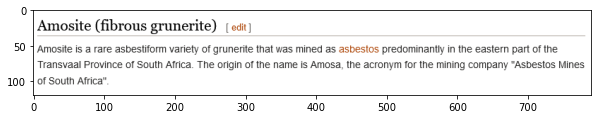

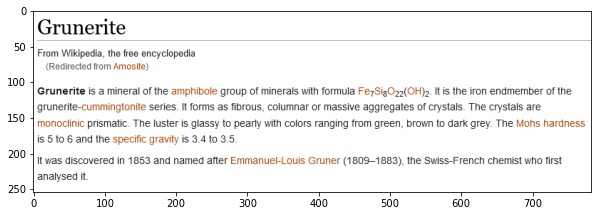

In [103]:
cwd = Path.cwd()
inputDir = cwd.joinpath('inputData')
inputDir = inputDir.joinpath('amosite')
inputScreenshot = inputDir.joinpath('screenshot.png')
inputText = inputDir.joinpath('text.txt')

with inputText.open('r') as f:
    trueText = f.read()

inputImage = cv2.imread(str(inputScreenshot))
image = cv2.cvtColor(inputImage, cv2.COLOR_BGR2RGB)

contours = contourWikipage(image)
content = []

for contour in contours:
    x,y,w,h = cv2.boundingRect(contour)
    croppedImage = inputImage[y:y+h, x:x+w]
    print(croppedImage.shape)
    isTextContent = checkWikiTextContent(croppedImage)
    
    if isTextContent:
        content.append(croppedImage)


# plotImage(inputImage, contours = contours)
for image in content:
    plotImage(image)

In [71]:
def criteriaToFill(image):
    string = pytesseract.image_to_string(image)
    string = ''.join(string.split())
    if len(string)>=13 and string[:13] == 'FromWikipedia':
        return True
    elif len(string)>=6 and string == '[edit]':
        return True
    return False

def fillText(image, criteriaToFill):

    contoursToFill = []
    img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (4,3))
    img = cv2.dilate(img, kernel, iterations=3)

    contours = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    
    
    for contour in contours:
        x,y,w,h = cv2.boundingRect(contour)
        croppedImage = image[y:y+h, x:x+w]
        toFill = criteriaToFill(croppedImage)
        if toFill:
            contoursToFill.append(contour)
        
    
    if contoursToFill != []:
        cv2.fillPoly(image, pts = contoursToFill, color=(255,255,255))    
    return image 

In [ ]:
content.reverse()

In [97]:
imageText = ''
for idx, image in enumerate(content):
    image = fillText(image, toFill)
    
    string = pytesseract.image_to_string(image)
    string = string.strip()
    imageText = imageText +'\n'+ string 
# print(imageText)

----------------------------------------
0
Grunerite

Grunerite is a mineral of the amphibole group of minerals with formula Fe7SigOz9(OH)2. It is the iron endmember of the
grunerite-cummingtonite series. It forms as fibrous, columnar or massive aggregates of crystals. The crystals are
monoclinic prismatic. The luster is glassy to pearly with colors ranging from green, brown to dark grey. The Mohs hardness
is 5 to 6 and the specific gravity is 3.4 to 3.5.

Itwas discovered in 1853 and named after Emmanuel-Louis Gruner (1809-1889), the Swiss-French chemist who first
analysed it
----------------------------------------
----------------------------------------
1
Amosite (fibrous grunerite)

‘Amosite is a rare asbestiform variety of grunerite that was mined as asbestos predominantly in the eastern part of the
Transvaal Province of South Africa. The origin of the name is Amosa, the acronym for the mining company "Asbestos Mines
of South Africa’
----------------------------------------


In [94]:
print(imageText)


Grunerite

Grunerite is a mineral of the amphibole group of minerals with formula Fe7SigOz9(OH)2. It is the iron endmember of the
grunerite-cummingtonite series. It forms as fibrous, columnar or massive aggregates of crystals. The crystals are
monoclinic prismatic. The luster is glassy to pearly with colors ranging from green, brown to dark grey. The Mohs hardness
is 5 to 6 and the specific gravity is 3.4 to 3.5.

Itwas discovered in 1853 and named after Emmanuel-Louis Gruner (1809-1889), the Swiss-French chemist who first
analysed it
Amosite (fibrous grunerite)

‘Amosite is a rare asbestiform variety of grunerite that was mined as asbestos predominantly in the eastern part of the
Transvaal Province of South Africa. The origin of the name is Amosa, the acronym for the mining company "Asbestos Mines
of South Africa’


In [95]:
print(trueText)

Grunerite
Grunerite is a mineral of the amphibole group of minerals with  formula Fe7Si8O22(OH)2. It is the iron endmember of the grunerite-cummingtonite series. It forms as fibrous, columnar or massive aggregates of crystals. The crystals are monoclinic prismatic. The luster is glassy to pearly with colors ranging from green, brown to dark grey. The Mohs hardness is 5 to 6 and the specific gravity is 3.4 to 3.5.
It was discovered in 1853 and named after Emmanuel-Louis Gruner (1809â€“1883), the Swiss-French chemist who first analysed it.

Amosite (fibrous grunerite)
Amosite is a rare asbestiform variety of grunerite that was mined as asbestos predominantly in the eastern part of the Transvaal Province of South Africa. The origin of the name is Amosa, the acronym for the mining company "Asbestos Mines of South Africa".



In [98]:
conda install nltk

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\User\anaconda3

  added / updated specs:
    - nltk


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-22.11.0              |   py39haa95532_1         932 KB
    ruamel.yaml-0.16.12        |   py39h2bbff1b_3         173 KB
    ruamel.yaml.clib-0.2.6     |   py39h2bbff1b_1         101 KB
    ------------------------------------------------------------
                                           Total:         1.2 MB

The following NEW packages will be INSTALLED:

  ruamel.yaml        pkgs/main/win-64::ruamel.yaml-0.16.12-py39h2bbff1b_3 None
  ruamel.yaml.clib   pkgs/main/win-64::ruamel.yaml.clib-0.2.6-py39h2bbff1b_1 None

The following packages will be UPDATED:

  conda              conda-forge::conda-22.9.0-py39hcbf530~ --> pkgs/main::conda-22.11.0-py39haa95532_1 None




conda-22.11.0      